# Multilayered perceptron (MLP)

### 0. MLP for regression

In [248]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

a)

In [249]:
df_mpg = sns.load_dataset("mpg").drop("name", axis = 1)
df_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


b)

In [250]:
df_mpg["origin"].value_counts()

usa       249
japan      79
europe     70
Name: origin, dtype: int64

In [251]:
df_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


c)

In [252]:
df_mpg.query("horsepower.isna()")

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,usa
126,21.0,6,200.0,NaN,2875,17.0,74,usa
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,usa
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,usa


In [253]:
nan_index = df_mpg.query("horsepower.isna()").index
nan_index

Int64Index([32, 126, 330, 336, 354, 374], dtype='int64')

In [254]:
bins = pd.IntervalIndex.from_tuples([(69, 73), (74, 77), (78, 82)])

df_mpg["model_year"] = pd.cut(df_mpg["model_year"], bins = bins)
df_mpg = pd.get_dummies(df_mpg, columns=["model_year", "origin"], drop_first=True)

In [255]:
from sklearn.impute import KNNImputer

In [256]:
imputer = KNNImputer(n_neighbors=2)
imputed = imputer.fit_transform(df_mpg)

df_imputed = pd.DataFrame(imputed, columns = df_mpg.columns)
df_mpg["horsepower"] = round(df_imputed["horsepower"])

d)

In [257]:
df_mpg[df_mpg.index.isin(nan_index)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,"model_year_(74, 77]","model_year_(78, 82]",origin_japan,origin_usa
32,25.0,4,98.0,66.0,2046,19.0,0,0,0,1
126,21.0,6,200.0,106.0,2875,17.0,0,0,0,1
330,40.9,4,85.0,60.0,1835,17.3,0,1,0,0
336,23.6,4,140.0,104.0,2905,14.3,0,1,0,1
354,34.5,4,100.0,63.0,2320,15.8,0,1,0,0
374,23.0,4,151.0,86.0,3035,20.5,0,1,0,1


None of the imputed values seems to be unreasonable.

e)

In [258]:
from sklearn.model_selection import train_test_split

X, y = df_mpg.drop("mpg", axis = 1).to_numpy(), df_mpg["mpg"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=.3, random_state=42)


### Function to create MLP

In [259]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
# from tensorflow.keras.optimizers import SGD

In [260]:
def MLP_model(layers):
    model = Sequential(name = "MLP_model")

    # input layer
    model.add(InputLayer(X_test.shape[1]))
    
    # hidden layers
    for i, nodes in enumerate(layers):
        model.add(Dense(nodes, name = f"Hidden_layer_{i+1}", activation = "relu"))

    # output layer
    model.add(Dense(1, name = "Output_layer"))

    model.compile(loss = "mean_squared_error", optimizer = "adam")
    return model

### Choose scaler method

In [265]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# scaled data with min max scaler
min_max_X_train = min_max_scaler.fit_transform(X_train_small)
min_max_X_val = min_max_scaler.transform(X_val)

# scaled data with standard scaler
standard_X_train = standard_scaler.fit_transform(X_train_small)
standard_X_val = standard_scaler.transform(X_val)

# hidden layers for test
layers_scaler_test = [16, 16]

# create model with min max scaled data
min_max_model_test = MLP_model(layers_scaler_test)
min_max_model_test.fit(min_max_X_train, y_train_small, epochs = 100, validation_data = (min_max_X_val, y_val), verbose = 0)

# create model with standard scaled data
standard_model_test = MLP_model(layers_scaler_test)
standard_model_test.fit(standard_X_train, y_train_small, epochs = 100, validation_data = (standard_X_val, y_val), verbose = 0)

<AxesSubplot:title={'center':'StandardScaler'}, xlabel='Epochs', ylabel='MSE loss'>

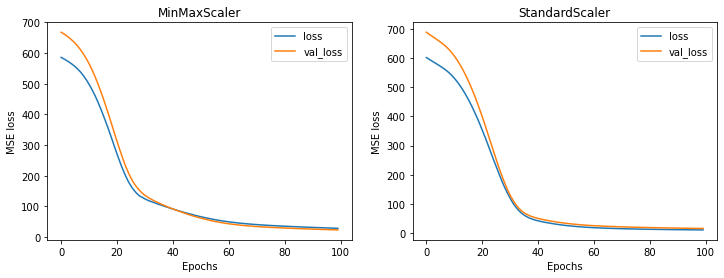

In [266]:
# get metrics from models
min_max_metrics = pd.DataFrame(min_max_model_test.history.history)
standard_metrics = pd.DataFrame(standard_model_test.history.history)

# plot metrics
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
min_max_metrics.plot(ax = axes[0], title = "MinMaxScaler", xlabel = "Epochs", ylabel = "MSE loss")
standard_metrics.plot(ax = axes[1], title = "StandardScaler", xlabel = "Epochs", ylabel = "MSE loss")

In [283]:
# choosing StandardScaler because it reaches a lower MSE loss with fewer epochs
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_small)
scaled_X_val = scaler.transform(X_val)

f)

In [324]:
def evaluate_model(layers):
    model = MLP_model(layers)
    model.fit(scaled_X_train, y_train_small, epochs = 20, validation_data = (scaled_X_val, y_val), verbose = 0)

    return pd.DataFrame(model.history.history)

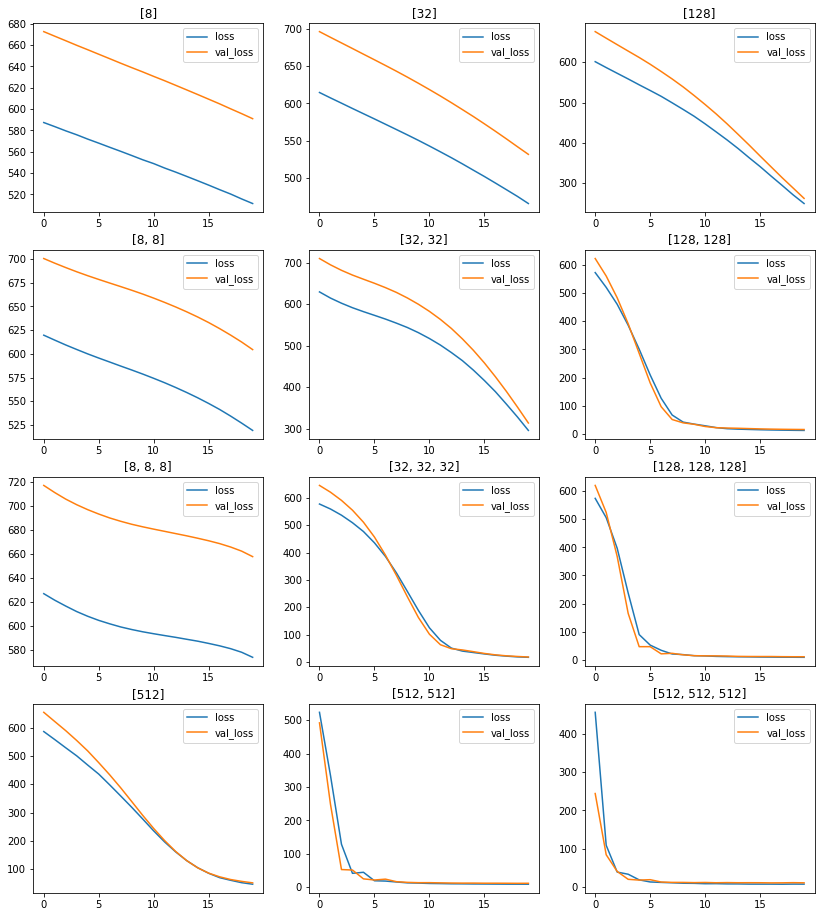

In [325]:
fig, axes = plt.subplots(4, 3, figsize = (14, 16))

for ax, nodes in zip(axes.flatten(), [[8], [32], [128], 
                                        [8, 8], [32, 32], [128, 128], 
                                        [8, 8, 8], [32, 32, 32], [128, 128, 128],
                                        [512], [512, 512], [512, 512, 512]]):
    test = evaluate_model(nodes)
    test.plot(ax = ax)
    ax.set_title(nodes)

g)

<AxesSubplot:>

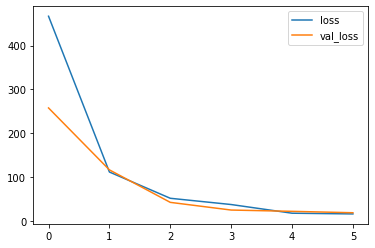

In [336]:
model = MLP_model([512, 512, 512])
model.fit(scaled_X_train, y_train_small, epochs = 6, validation_data = (scaled_X_val, y_val), verbose = 0)
metrics = pd.DataFrame(model.history.history)
metrics.plot()

choosing 4 epochs

h)

In [337]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

model = MLP_model([512, 512, 512])
model.fit(scaled_X_train, y_train, epochs = 4, verbose = 0)

i)

In [349]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(scaled_X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

MAE: 2.64
RMSE: 3.27


j)

In [354]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(scaled_X_train, y_train)
y_pred_random_forest = random_forest.predict(scaled_X_test)

print(f"MAE {mean_absolute_error(y_test, y_pred_random_forest):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_random_forest)):.2f}")

MAE 1.60
RMSE: 2.04


This will be very hard to beat.